# Run the LFADS algorithm on an RNN that integrates white noise.

The goal of this tutorial is to learn about LFADS by running the algorithm on a simple data generator, a vanilla recurrent neural network (RNN) that was [trained to integrate a white noise input](https://github.com/google-research/computation-thru-dynamics/blob/master/notebooks/Integrator%20RNN%20Tutorial.ipynb).  Running LFADS on this integrator RNN will infer two things:
1. the underlying hidden state of the integrator RNN
2. the white noise input to the integrator RNN.

Doing this will exercise the more complex LFADS architecture that is shown in Figure 5 of the [LFADS paper](https://rdcu.be/6Wji). It's pretty important that you have read at least the introduction of the paper, otherwise you won't understand *why* we are doing what we are doing.

In this tutorial we do a few things:
1. Load the integrator RNN data and "spikify" it by treating the hidden units as nonhomogeneous Poisson processes.
2. Explain a bit of the of the LFADS architecture and highlight some of the relevant hyperparameters.
3. Train the LFADS system on the spikified integrator RNN hidden states.
4. Plot a whole bunch of training plots and LFADS outputs!

If you make it through this tutorial and understand everything in it, it is *highly* likely you'll be able to run LFADS on your own data.


#### Copyright 2019 Google LLC

Licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the License.
You may obtain a copy of the License at

     https://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
See the License for the specific language governing permissions and
limitations under the License.

### Import the tutorial code.

If you are going to actually run the tutorial, you have to install JAX, download the computation thru dynamics github repo, and modify a path. 

In [1]:
# Numpy, JAX, Matplotlib and h5py should all be correctly installed and on the python path.
from __future__ import print_function, division, absolute_import

import datetime
import h5py
import jax.numpy as np
from jax import random
from jax.experimental import optimizers
from jax.config import config
#config.update("jax_debug_nans", True) # Useful for finding numerical errors
import matplotlib.pyplot as plt
import numpy as onp  # original CPU-backed NumPy
import os
import sys
import time

In [2]:
# You must change this to the location of computation-thru-dynamics directory.
HOME_DIR = '/home/sussillo/' 

sys.path.append(os.path.join(HOME_DIR,'computation-thru-dynamics'))
import lfads_tutorial.lfads as lfads
import lfads_tutorial.plotting as plotting
import lfads_tutorial.utils as utils
from lfads_tutorial.optimize import optimize_lfads, get_kl_warmup_fun

### Preliminaries - notes on using JAX

JAX is amazing! It's really, really AMAZING! You program in Numpy/Python and then call a grad on your code, and it'll run speedy on GPUs! It does however have a few quirks and it uses a program deployment model you have to know about. The excited reader should definitely read the [JAX tutorial](https://github.com/google/jax), if they plan on programming with it. 

When using JAX for auto diff, auto batching or compiling, you should always have a two-level mental model in your mind: 
1. At the CPU level, like normal
2. at the device level, for example a GPU. 

Since JAX compiles your code to device, it is very efficient but creates this split.  Thus, for example, we have two NumPY modules kicking around: 'onp' for 'original numpy', which is on the CPU, and np, which is the JAX modified version and runs 'on device'.  This latter version of numpy is enabled to compute gradients and run your code quickly.

So the model then is: initialize variables, seeds, etc, at the CPU level, and *dispatch* a JAX based computation to the device. This all happens naturally whenever you call JAX enabled functions.

Thus one of the first things we do initialize the onp random number generator at the CPU level.

In [3]:
onp_rng = onp.random.RandomState(seed=None) # For CPU-based numpy randomness

----------

### Load the data

You __must__ run through the the integrator RNN [tutorial notebook](https://github.com/google-research/computation-thru-dynamics/blob/master/notebooks/Integrator%20RNN%20Tutorial.ipynb) on your machine. Don't worry! It's much simpler than this tutorial! :) 

Point to the correct __data__  file for the integrator RNN. Note that the integrator rnn tutorial notebook creates two files, both the parameters file and the data file with examples.

In [4]:
INTEGRATOR_RNN_DATA_FILE = \
    '/tmp/vrnn/pure_int/trained_data_vrnn_pure_int_0.00003_2019-03-23_21:46:32.h5'

lfads_dir = '/tmp/lfads/'       # where to save lfads data and parameters to
rnn_type = 'lfads'
task_type = 'integrator'

In [5]:
# Make directories
data_dir = os.path.join(lfads_dir, 'data/')
output_dir = os.path.join(lfads_dir, 'output/')
figure_dir = os.path.join(lfads_dir, os.path.join(output_dir, 'figures/'))
if not os.path.exists(output_dir):
    os.makedirs(output_dir)
if not os.path.exists(figure_dir):
    os.makedirs(figure_dir)

# Load synthetic data
data_dict = utils.read_file(INTEGRATOR_RNN_DATA_FILE)

### Plot examples and statistics about the integrator RNN data.

Number of data examples:  10240
Number of timesteps:  25
Number of data dimensions:  100


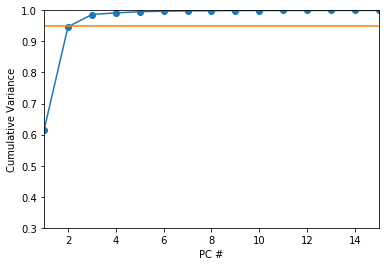

In [6]:
f = plotting.plot_data_pca(data_dict)

The goal of this tutorial is to infer the hiddens (blue), and input to the integrator RNN (umm... also blue).

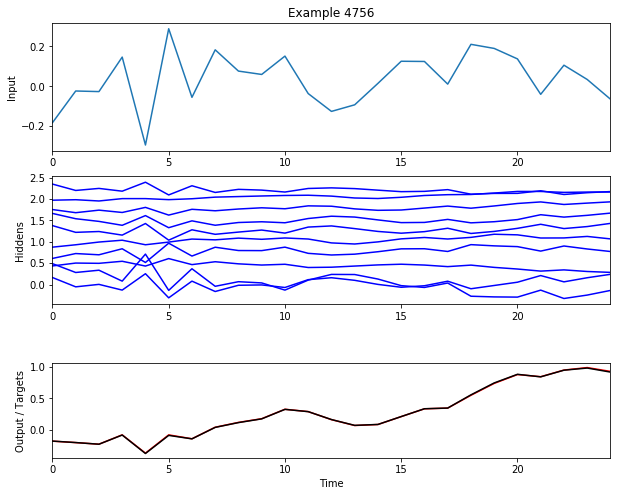

In [7]:
f = plotting.plot_data_example(data_dict['inputs'], 
                               data_dict['hiddens'],
                               data_dict['outputs'], 
                               data_dict['targets'])

### Spikify the synthetic data
The output of the integrator rnn is the continuous inputs,
hidden states and outputs of the example.  LFADS is a tool 
to infer underlying factors in spiking neural data, so we 
are going to "spikify" the integrator rnn example hidden states.

Data was generated w/ VRNN w/ tanh, thus $(\mbox{data}+1) / 2 \rightarrow [0,1]$. 
We put those activations between 0 and 1 here and then convert to spikes.

In [8]:
data_dt = 1.0/25.0        # define our dt in a physiological range

# If data is normed between 0 and 1, then a 1 yields this many 
# spikes per second. Pushing this downwards makes the problem harder.
max_firing_rate = 40      
train_fraction = 0.9      # Train with 90% of the synthetic data

renormed_fun = lambda x : (x + 1) / 2.0

renormed_data = renormed_fun(data_dict['hiddens'])

# When dimensions are relevant, I use a variable naming scheme like
# name_dim1xdim2x...  so below, here is the synthetic data with 
# 3 dimensions of batch, time and unit, in that order.
data_bxtxn = utils.spikify_data(renormed_data, onp_rng, data_dt,
                                max_firing_rate=max_firing_rate)
train_data, eval_data = utils.split_data(data_bxtxn,
                                         train_fraction=train_fraction)
eval_data_offset = int(train_fraction * data_bxtxn.shape[0])

#### Plot the statistics of the data.

19.9952431640625 spikes/second


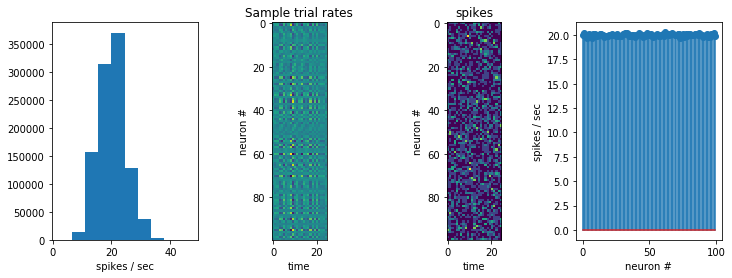

In [9]:
f = plotting.plot_data_stats(data_dict, data_bxtxn, data_dt)

If you were to increase max_firing_rate to infinity, the
stem plot below would approach the red line. This plot gives you an
idea of how challenging the data set is, at least on single trials. So *I think*, though I do know for sure, that we have this problem calibrated reasonably hard.

<StemContainer object of 3 artists>

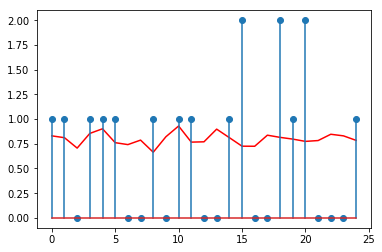

In [10]:
bidx = 0
hidx = onp.random.randint(0, 100)
scale = max_firing_rate * data_dt
plt.plot(scale*renormed_data[bidx,:,hidx], 'r');
plt.stem(data_bxtxn[bidx,:,hidx]);

----------------

## LFADS - Latent Factor Analysis via Dynamical Systems


[Link to paper readcube version of the LFADS Nature Methods 2018 paper](https://rdcu.be/6Wji)



### LFADS architecture with inferred inputs

There are 3 variants of the LFADS architecture in the paper
1. autonomous LFADS model (no inferred inputs), Fig. 1a
2. stitched LFADS model for data recorded in different sessions, Fig. 4a
3. non-autonomous LFADS model (with inferred inputs), Fig. 5a

In this tutorial we deal with the non-autonomous model, which I believe is conceptually the most interesting, but also the most challenging to understand.  This tutorial (and the current code), does **NOT** handle stitched data.  Stitching data isn't conceptually hard, but it's a pain to code.  The Tensorflow version of the code handles that, if you need it. 

Here is the non-autonoumous LFADS model architecture: The full description of this model is given in the paper but briefly, the idea is that the data LFADS will 'denoise' or model data generated from a nonlinear, autonoumous system (we call it the data generator and the data generator in this tutorial is the integrator RNN) that receives an input through time. Based on the spiking observations, LFADS will try to pull apart the data into the dynamical system portion, and the input portion, thus the term *inferred inputs*.  I.e. we are trying to infer what inputs would drive a high-d nonlinear system to generate the data you've recorded. Doing this allows the system to model the dynamics much better for systems that are input driven. One final detail is that the model assumes that the spikes are poisson generated from an underlying continuous dynamical system. Of course, this is not true for spiking data from biological neural circuits, but the poisson approximation seems to be ok.

So architecture infers a number of quantities of interest: 
1. initial state to generator (also called initial conditions)
2. inferred inputs to generator - e.g. the LFADS component to learn the white noise in the integrator RNN example
3. dynamical factors - these are like PCs underlying your data
4. rates - a readout from the factors. The rates are really the most intuitive part, which are analogous to filtering your spiking data. 

![](https://raw.githubusercontent.com/google-research/computation-thru-dynamics/master/images/lfads_architecture_w_inferred_inputs_3.png)


To begin, let's focus on the *autonomous* version of the architecture, which *excludes the controller RNN*.  The data is put through nonlinear, recurrent **encoders**, and this produces an **initial state distribtion**, which is a per-trial mean and variance to produce random vectors to encode that trial. The initial state of the generator is a randomly drawn vector from this distribution. The **generator** marches through time and at each time point produces **factors** and **rates**, ultimately producing outputs that learn to reproduce your data at the rate level.  


From the perspective on information flow, the automous version of LFADS has a *bottleneck* between your data as inputted into LFADS, and the output, which also tries to learn your data. That bottleneck is the inital state of the generator, a potentially very low-bandwidth bottleneck, as a single vector has to encode a high-d time series. Such a system would be adequate for capturing systems that are (in approximation) autonomous.  For example, motor cortex dynamics during center-out reaches seem extremely well approximated by autonomous dynamics at the sub-second time scale (e.g. Fig 2). However, if you were to perturb the reach by messing with the cursor the animal was using, e.g perturbing cursor location mid-reach, then the motor cortical dynamics of a corrected reach couldn't possibly be autonomous.  In other words, some additional input must have come into the motor cortex and update the system with the information that the cursor had jumped unexpectedly.  This is the experimental setting we setup in Fig. 5.

To compensate for such a scenario, we added a **controller** and **inferred inputs** to the generator portion of LFADS.  In particular, the controller runs in sync with the generator and receives the output of the generator from the last time step (the only "backward" loop in the architecture, aside from using backprop for training with gradient descent).  Thus it it knows what the generator output.  During training, the system learns that there are patterns in the data that cannot be created by the generator autonomously, so learns to compensate by emitting information from the data, through the encoders, through the controller to the generator.  We call this information an inferred input. In our experimental setup, this worked well on two examples: messing with the cursor of an animal making a reach and also for inferring oscillations in the local field potiential (LFP).

Please note that the inferred input system is extremely powerful as it provides a leak from the your input data to the LFADS output on a per-time point basis. As such, one has to make sure that the system  does not pathologically leak all the information from the data trial through LFADS to generate the data trial. LFADS, like all auto-encoders, is at risk of creating a trivial identity function, $x = f(x)$, rather than finding stucture in the data. Thus, we utilize many tricks to avoid this (dropout, KL penalties, and even blocking out information given to the controller from time step t, when decoding time step t.)

### Hyperparameters

In [11]:
# LFADS Hyper parameters
data_dim = train_data.shape[2]  # input to lfads should have dimensions:
ntimesteps = train_data.shape[1] #   (batch_size x ntimesteps x data_dim)
batch_size = 128      # batch size during optimization

# LFADS architecture - The size of the numbers is rather arbitrary, 
# but relatively small because we know the integrator RNN isn't too high 
# dimensional in its activity.
enc_dim = 64          # encoder dim
con_dim = 64          # contoller dim
ii_dim = 1            # inferred input dim
gen_dim = 75          # generator dim
factors_dim = 20      # factors dim

# Numerical stability
var_min = 0.001 # Minimal variance any gaussian can become.

# Optimization HPs that percolates into model
l2reg = 0.00002      # amount of l2 on weights

### Hyperparameters for Priors

As was mentioned above, LFADS is an auto-encoder and auto-encoders typically encode data through some kind of information bottleneck.  The idea is a lot like PCA, if one gets rid unimportant variation, then perhaps meaningful and interesting structure in the data will become apparent.  

More precisely, LFADS is a variational auto-encoder (VAE), which means that the bottleneck is achieved via probabilistic methods.  Namely, each trial intial state is encoded in a per-trial Gaussian distribution called the 'posterior', e.g. initial state parameter's mean and varaince are given by $(\mu(\mathbf{x}), \sigma^2(\mathbf{x}))$, where $\mathbf{x}$ is the data.  This then is compared to an *uninformative prior* $(\mu_p, \sigma^2_p)$, which is independent of the trial. A type of distance for distributions is used, called the KL-divergence, to force the initial state Gaussian distribution for each trial to be as close to as possible to a Gaussian that doesn't depend on the trial. This is a part of the **ELBO** - Evidence lower bound - that is used to train VAEs.

In [12]:
# Initial state prior parameters
# the mean is set to zero in the code
ic_prior_var = 0.1 # this is $\sigma^2_p$ in above paragraph

### Hyper parameters for inferred inputs

The inferred inputs are also codes represented by posterior distributions, but now *each time point* is a Gaussian, so each inferred input time series is really a Gaussian process, called [autoregressive-1](https://en.wikipedia.org/wiki/Autoregressive_model#Example:_An_AR(1)_process) or AR-1 for short. 

$s_t = c + \phi s_{t-1} + \epsilon_t, \mbox{ with } \epsilon_t \in N(0, \sigma^2_n) $

with c the process mean, $\phi$ giving dependence of process state at time $t-1$ to process state at time $t$ and $\epsilon_t$ is the noise with variance $\sigma^2_n$.

So if you have 4 inferred inputs, then you have 4 AR-1 processes. Each AR-1 process is a posterior distribution *over sequences* and this allows us to introduce another useful concept, the auto-correlation of each sequence. The auto-correlation is the correlation between values in the process at different time points.  We are interested in auto-correlation because we may want to penalize very jagged or very smooth inferred inputs on a task by task case, as well as for other technical reasons.

So just like the initial states, which introduced multi-variate gaussian distributions (the posteriors) for each data trial and an uninformative prior to which the per-trial posteriors are compared, we do the same thing with inferred inputs, now using the KL-divergence to compare the distribution of of auto-regressive sequences to uninformative auto-regressive prior for sequences. In this way, we aim to limit how informative the inferred inputs are by introducing a bottleneck between the encoder and the generator.

In [13]:
# Inferred input autoregressive prior parameters
ar_mean = 0.0                 # process mean
ar_autocorrelation_tau = 1.0  # seconds, how correlated each time point is, related to $\phi$ above.
ar_noise_variance = 0.1       # noise variance

In [14]:
lfads_hps = {'data_dim' : data_dim, 'ntimesteps' : ntimesteps,
             'enc_dim' : enc_dim, 'con_dim' : con_dim, 'var_min' : var_min,
             'ic_prior_var' : ic_prior_var, 'ar_mean' : ar_mean,
             'ar_autocorrelation_tau' : ar_autocorrelation_tau,
             'ar_noise_variance' : ar_noise_variance,
             'ii_dim' : ii_dim, 'gen_dim' : gen_dim,
             'factors_dim' : factors_dim,
             'l2reg' : l2reg,
             'batch_size' : batch_size}

In [15]:
# LFADS Optimization hyperparameters
num_batches = 12000              # how many batches do we train
print_every = 50                # give information every so often
step_size = 0.05               # initial learning rate
decay_factor = 0.99975            # learning rate decay param
decay_steps = 1                 # learning rate decay param
keep_rate = 0.98                # dropout keep rate during training
max_grad_norm = 10.0            # gradient clipping above this value
l2reg = 0.00002      # amount of l2 on weights (in lfads_hps)

### Warming up the KL penalties 
The optimization of a VAE optimizes the ELBO, which is

$L(\theta) = -\mathop{\mathbb{E}}_x \left(\log p_\theta(x|z) + KL(q_\theta(z|x) \;\;|| \;\;p(z))\right)$

* $p_\theta(x|z)$ - the reconstruction given the initial state and inferred inputs codes (collectively denoted $z$  here)

* $q_\theta(z|x)$ - represents the latent variable posterior distributions (the data encoders that ultimately yield the intial state and inferred input codes).

* $p(z)$ - the prior that does not know about the data

where $\theta$ are all the parameters. This is an expectation over all your data, $x$, of the quality of the generation $p_\theta(x|z)$ plus the KL diverengence penality mentioned above that compares the distributions for the initial state and inferred inputs.

It turns out that the KL term can be a lot easier to optimize initially than learning how to reconstruct your data. This results in a pathological stoppage of training where the KL goes to nearly zero and training is broken there on out (as you cannot respresent any data from uninformative priors).  One way out of this is to warmup the KL penality, starting it off with a weight term of 0 and then slowly building to 1, giving the reconstruction a chance to train a bit without the KL penalty messing things up.

In [16]:
kl_warmup_start = 500.0 # batch number to start kl warmup, explicitly float
kl_warmup_end = 1000.0  # batch number to be finished with kl warmup, explicitly float
kl_min = 0.01 # The minimmum KL value, non-zero to make sure KL doesn't grow crazy before kicking in.

Note, there is currently a HUGE amount of debate about what the correct parameter value here is for the KL penalty. kl_max = 1 is what creates a lower bound on the (marginal) log likelihood of the data, but folks argue it could be higher or lower than 1. Myself, I have never played around with this HP, but I have the idea that LFADS may benefit from < 1 values, as LFADS is not really being used for generation.

See [$\beta$-VAE: LEARNING BASIC VISUAL CONCEPTS WITH A
CONSTRAINED VARIATIONAL FRAMEWORK](https://openreview.net/pdf?id=Sy2fzU9gl)

See [Fixing a Broken ELBO](https://arxiv.org/pdf/1711.00464.pdf) as to why you might choose a particular kl maximum value.  I found this article pretty clarifying.

In [17]:
kl_max = 1.0

In [18]:
lfads_opt_hps = {'num_batches' : num_batches, 'step_size' : step_size,
                 'decay_steps' : decay_steps, 'decay_factor' : decay_factor,
                 'kl_min' : kl_min, 'kl_max' : kl_max, 'kl_warmup_start' : kl_warmup_start,
                 'kl_warmup_end' : kl_warmup_end, 'keep_rate' : keep_rate,
                 'max_grad_norm' : max_grad_norm, 'print_every' : print_every,
                 'adam_b1' : 0.9, 'adam_b2' : 0.999, 'adam_eps' : 1e-1}

assert num_batches >= print_every and num_batches % print_every == 0

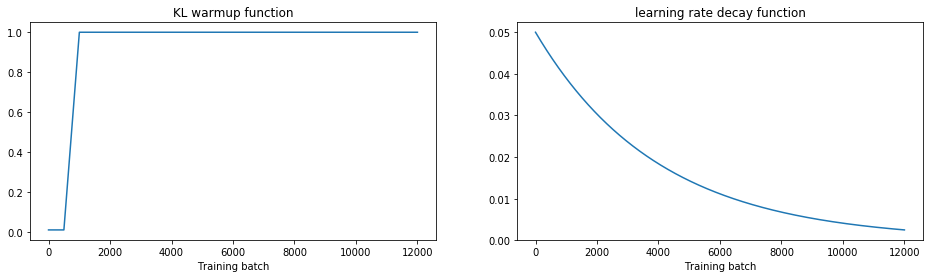

In [19]:
# Plot the warmup function and the learning rate decay function.
plt.figure(figsize=(16,4))
plt.subplot(121)
kl_warmup_fun = get_kl_warmup_fun(lfads_opt_hps)
plt.plot([kl_warmup_fun(i) for i in range(lfads_opt_hps['num_batches'])]);
plt.title('KL warmup function')
plt.xlabel('Training batch');

plt.subplot(122)
decay_fun = optimizers.exponential_decay(lfads_opt_hps['step_size'],                                                             
                                         lfads_opt_hps['decay_steps'],                                                           
                                         lfads_opt_hps['decay_factor'])                                                          
plt.plot([decay_fun(i) for i in range(lfads_opt_hps['num_batches'])]);
plt.title('learning rate decay function')
plt.xlabel('Training batch');                                                                                     

### Train the LFADS model

Note that JAX uses it's own setup to handle randomness and seeding the pseudo-random number generators.  You can read about it [here](https://github.com/google/jax/blob/master/README.md#random-numbers-are-different). If you want to modify the LFADS tutorial you *NEED* to understand this. Otherwise, not so big a deal if you are just messing around with LFADS hyperparameters or applying the tutorial to new data.

In [20]:
# Initialize parameters for LFADS
key = random.PRNGKey(onp.random.randint(0, utils.MAX_SEED_INT))
init_params = lfads.lfads_params(key, lfads_hps)

In [21]:
# Note that the first loop could take a few minutes to run, 
# because the LFADS model is unrolled, and therefor the JIT
# (just in time) compilation is slow, and happens "just in time", 
# which is the first training loop iteration. On my computer, the 
# JIT compilation takes a few minutes.

# You'll see the loss go up when the KL warmup starts turning on.

# Note this will occasionally "nan out" when the KL comes on, 
# if you see nans, just restart with another random key. I am not
# certain why this is happening, probably a large glitch in the gradient.
key = random.PRNGKey(onp.random.randint(0, utils.MAX_SEED_INT))
trained_params, opt_details = \
    optimize_lfads(key, init_params, lfads_hps, lfads_opt_hps,
                   train_data, eval_data)

Batches 1-50 in 206.40 sec, Step size: 0.04938, Training loss 2493, Eval loss 2491
Batches 51-100 in 3.58 sec, Step size: 0.04877, Training loss 2435, Eval loss 2436
Batches 101-150 in 3.61 sec, Step size: 0.04816, Training loss 2429, Eval loss 2430
Batches 151-200 in 3.68 sec, Step size: 0.04756, Training loss 2431, Eval loss 2432
Batches 201-250 in 3.65 sec, Step size: 0.04697, Training loss 2434, Eval loss 2435
Batches 251-300 in 3.59 sec, Step size: 0.04639, Training loss 2434, Eval loss 2434
Batches 301-350 in 3.64 sec, Step size: 0.04581, Training loss 2445, Eval loss 2443
Batches 351-400 in 3.59 sec, Step size: 0.04524, Training loss 2436, Eval loss 2439
Batches 401-450 in 3.61 sec, Step size: 0.04468, Training loss 2439, Eval loss 2443
Batches 451-500 in 3.65 sec, Step size: 0.04412, Training loss 2455, Eval loss 2448
Batches 501-550 in 3.61 sec, Step size: 0.04358, Training loss 2450, Eval loss 2450
Batches 551-600 in 3.59 sec, Step size: 0.04303, Training loss 2452, Eval loss

Batches 4801-4850 in 3.57 sec, Step size: 0.01487, Training loss 2450, Eval loss 2451
Batches 4851-4900 in 3.57 sec, Step size: 0.01469, Training loss 2450, Eval loss 2450
Batches 4901-4950 in 3.59 sec, Step size: 0.01450, Training loss 2452, Eval loss 2451
Batches 4951-5000 in 3.60 sec, Step size: 0.01432, Training loss 2450, Eval loss 2449
Batches 5001-5050 in 3.59 sec, Step size: 0.01415, Training loss 2450, Eval loss 2447
Batches 5051-5100 in 3.63 sec, Step size: 0.01397, Training loss 2449, Eval loss 2448
Batches 5101-5150 in 3.55 sec, Step size: 0.01380, Training loss 2448, Eval loss 2451
Batches 5151-5200 in 3.56 sec, Step size: 0.01362, Training loss 2449, Eval loss 2451
Batches 5201-5250 in 3.57 sec, Step size: 0.01346, Training loss 2449, Eval loss 2450
Batches 5251-5300 in 3.80 sec, Step size: 0.01329, Training loss 2450, Eval loss 2449
Batches 5301-5350 in 3.62 sec, Step size: 0.01312, Training loss 2451, Eval loss 2451
Batches 5351-5400 in 3.56 sec, Step size: 0.01296, Tra

Batches 9601-9650 in 3.62 sec, Step size: 0.00448, Training loss 2447, Eval loss 2448
Batches 9651-9700 in 3.58 sec, Step size: 0.00442, Training loss 2448, Eval loss 2450
Batches 9701-9750 in 3.55 sec, Step size: 0.00437, Training loss 2449, Eval loss 2448
Batches 9751-9800 in 3.64 sec, Step size: 0.00431, Training loss 2449, Eval loss 2451
Batches 9801-9850 in 3.59 sec, Step size: 0.00426, Training loss 2447, Eval loss 2451
Batches 9851-9900 in 3.60 sec, Step size: 0.00421, Training loss 2450, Eval loss 2448
Batches 9901-9950 in 3.58 sec, Step size: 0.00415, Training loss 2448, Eval loss 2448
Batches 9951-10000 in 3.58 sec, Step size: 0.00410, Training loss 2447, Eval loss 2448
Batches 10001-10050 in 3.52 sec, Step size: 0.00405, Training loss 2450, Eval loss 2449
Batches 10051-10100 in 3.63 sec, Step size: 0.00400, Training loss 2448, Eval loss 2448
Batches 10101-10150 in 3.60 sec, Step size: 0.00395, Training loss 2448, Eval loss 2450
Batches 10151-10200 in 3.56 sec, Step size: 0.0

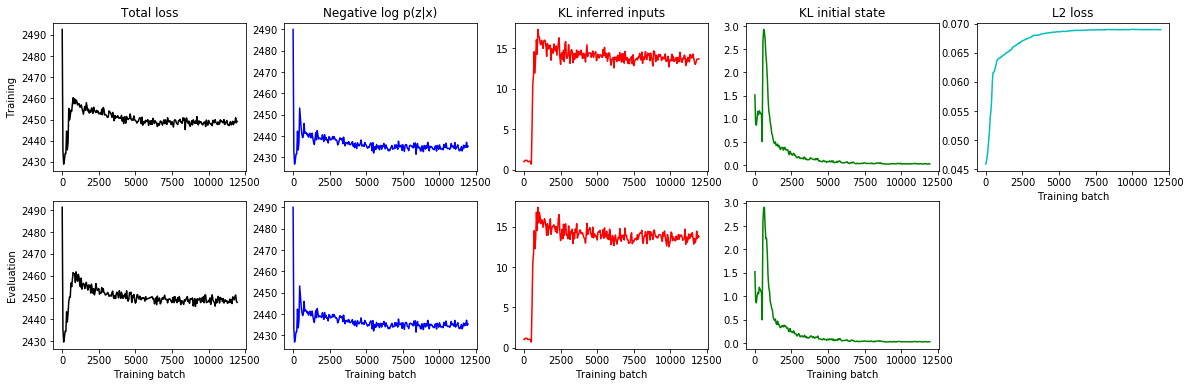

In [22]:
# Plot the training details
x = onp.arange(0, num_batches, print_every)
plt.figure(figsize=(20,6))
plt.subplot(251)
plt.plot(x, opt_details['tlosses']['total'], 'k')
plt.ylabel('Training')
plt.title('Total loss')
plt.subplot(252)
plt.plot(x, opt_details['tlosses']['nlog_p_xgz'], 'b')
plt.title('Negative log p(z|x)')
plt.subplot(253)
plt.plot(x, opt_details['tlosses']['kl_ii'], 'r')
plt.title('KL inferred inputs')
plt.subplot(254)
plt.plot(x, opt_details['tlosses']['kl_g0'], 'g')
plt.title('KL initial state')
plt.subplot(255)
plt.plot(x, opt_details['tlosses']['l2'], 'c')
plt.xlabel('Training batch')
plt.title('L2 loss')
plt.subplot(256)
plt.plot(x, opt_details['elosses']['total'], 'k')
plt.xlabel('Training batch')
plt.ylabel('Evaluation')
plt.subplot(257)
plt.plot(x, opt_details['tlosses']['nlog_p_xgz'], 'b')
plt.xlabel('Training batch')
plt.subplot(258)
plt.plot(x, opt_details['elosses']['kl_ii'], 'r')
plt.xlabel('Training batch')
plt.subplot(259)
plt.plot(x, opt_details['elosses']['kl_g0'], 'g')
plt.xlabel('Training batch');

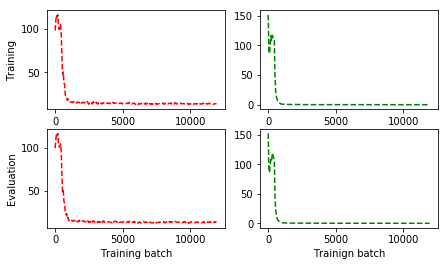

In [23]:
# See the effect of the KL warmup. 
plt.figure(figsize=(7,4))
plt.subplot(221)
plt.plot(x, opt_details['tlosses']['kl_ii_prescale'], 'r--')
plt.ylabel('Training')
plt.subplot(222)
plt.plot(x, opt_details['tlosses']['kl_g0_prescale'], 'g--')
plt.subplot(223)
plt.plot(x, opt_details['elosses']['kl_ii_prescale'], 'r--')
plt.ylabel('Evaluation')
plt.xlabel('Training batch')
plt.subplot(224)
plt.plot(x, opt_details['elosses']['kl_g0_prescale'], 'g--')
plt.xlabel('Trainign batch');

### Save the LFADS model parameters

In [24]:
fname_uniquifier = datetime.datetime.now().strftime("%Y-%m-%d_%H:%M:%S")
network_fname = ('trained_params_' + rnn_type + '_' + task_type + '_' + \
                 fname_uniquifier + '.npz')
network_path = os.path.join(output_dir, network_fname)

# Note we are just using numpy save instead of h5 because the LFADS parameter 
# is nested dictionaries, something I couldn't get h5 to save down easily.
print("Saving parameters: ", network_path)
onp.savez(network_path, trained_params)

Saving parameters:  /tmp/lfads/output/trained_params_lfads_integrator_2019-04-04_20:21:08.npz


In [89]:
# After training, you can load these up, after locating the save file.
if False:
    loaded_params = onp.load(network_path)
    trained_params = loaded_params['arr_0'].item()

### LFADS Visualization
To plot the results of LFADS, namely the inferred quantities such as the inferred inputs, factors, or rates, we have to do a sample-and-average operation.  Remember, the latent variables for LFADS are the initial state and the inferred inputs, and they are per-trial *stochastic* codes.  To get good inference, we sample a large number of times from these stochastic latent variables, run the generator forward, and then average all the quantities of interest over the samples. 

If LFADS were linear, it would be equivalent to do the *much more efficient decode* of the posterior means, that is, just take the average of the initial state and the average of the inferred input, and then run the decoder one time. (This, btw, is a great exercise to the tutorial reader, implement posterior-mean decoding in this tutorial.)

Here we use batching and take the 'posterior average' using batch number of samples from the latent variable distributions.

bidx:  10102


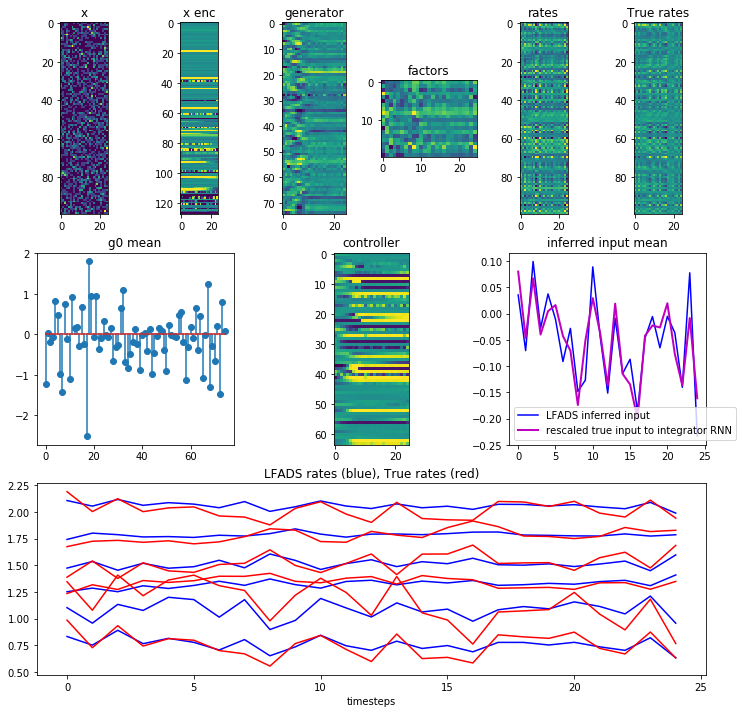

In [95]:
# Plot a bunch of examples of eval trials run through LFADS.
reload(plotting)

def plot_rescale_fun(a): 
    fac = max_firing_rate * data_dt
    return renormed_fun(a) * fac

bidx = 10102-eval_data_offset # straight up cherry picking. :) 

nexamples_to_save = 1
for eidx in range(nexamples_to_save):
    #bidx = onp.random.randint(eval_data.shape[0])
    psa_example = eval_data[bidx,:,:].astype(np.float32)
    # Make an entire batch of a single, example, and then
    # randomize the VAE with batchsize number of keys.
    examples = onp.repeat(np.expand_dims(psa_example, axis=0),
                          batch_size, axis=0)
    skeys = random.split(key, batch_size)
    lfads_dict = lfads.batch_lfads_jit(trained_params, lfads_hps, skeys,
                                       examples, 1.0)
    # posterior sample and average    
    psa_example_dict = utils.average_lfads_batch(lfads_dict) 

    # The inferred input and true input are rescaled and shifted via 
    # linear regression to match, as there is an identifiability issue. there.
    plotting.plot_lfads(psa_example, psa_example_dict,
                        data_dict, eval_data_offset+bidx, plot_rescale_fun)
    
    #plt.savefig(os.path.join(figure_dir, 'lfads_output_%d.png'%(bidx)))